In [42]:
import pandas as pd
import numpy as np

from typing import List, Tuple, Union, Dict

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
import geocoder

from sklearn.linear_model import Ridge

In [2]:
class Config:
    train_path = "../input/train_v2.csv"
    test_path = "../input/test_v2.csv"
    sample_submission_path = "../input/sample_submission.csv"
    output_path = "../submission/"
    seed = 42
    n_splits = 2

    



In [3]:
df_train = pd.read_csv(Config.train_path)
df_test = pd.read_csv(Config.test_path)


In [4]:
# 参考
# https://comp.probspace.com/competitions/pollen_counts/discussions/kotrying-Post833da695e2f337e5a86f


import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer



In [5]:
# データがv2になってから花粉飛散量がマイナスのがある。削除する。

print("Before",df_train.shape)

cond1 = df_train["pollen_tokyo"] >= 0
cond2 = df_train["pollen_chiba"] >= 0
cond3 = df_train["pollen_utsunomiya"] >= 0

df_train = df_train[cond1 & cond2 & cond3].reset_index(drop=True)
print("after",df_train.shape)

Before (12240, 16)
after (12132, 16)


In [6]:
df_train = df_train.replace("欠測", np.nan)
lgb_imp = IterativeImputer(
    estimator=LGBMRegressor(num_boost_round=1000, random_state=Config.seed),
    max_iter=10,
    initial_strategy="mean",
    imputation_order="ascending",
    verbose=1,
    random_state=Config.seed,
)

df_train = pd.DataFrame(lgb_imp.fit_transform(df_train), columns=df_train.columns)


[IterativeImputer] Completing matrix with shape (12132, 16)


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Foun

[IterativeImputer] Change: 11.00595193435774, scaled tolerance: 2020033.124 
[IterativeImputer] Early stopping criterion reached.


In [7]:
# 型がfloatになってしまっているので、もどす。
df_train[["winddirection_chiba", "winddirection_tokyo"]] = (
    df_train[["winddirection_chiba", "winddirection_tokyo"]].round().astype(int)
)
df_train[
    [
        "precipitation_tokyo",
        "temperature_chiba",
        "temperature_tokyo",
        "windspeed_chiba",
        "windspeed_tokyo",
    ]
] = df_train[
    [
        "precipitation_tokyo",
        "temperature_chiba",
        "temperature_tokyo",
        "windspeed_chiba",
        "windspeed_tokyo",
    ]
].round(
    1
)
df_train["datetime"] = df_train["datetime"].astype(int)

# df_train[df_train.select_dtypes(object).columns] = df_train[df_train.select_dtypes(object).columns]
df_train.head(3)


,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,windspeed_utsunomiya,windspeed_chiba,windspeed_tokyo,pollen_utsunomiya,pollen_chiba,pollen_tokyo
0,2017020101,0.0,0.0,0.0,-1.0,4.1,2.9,16.0,1,2,2.7,2.5,1.3,0.0,8.0,0.0
1,2017020102,0.0,0.0,0.0,-1.1,4.2,2.6,1.0,1,1,3.3,1.5,0.9,0.0,24.0,4.0
2,2017020103,0.0,0.0,0.0,-0.7,4.2,2.4,1.0,15,16,4.0,1.7,0.6,4.0,32.0,12.0


In [8]:
loc_list = ["宇都宮市中央生涯学習センター", "千葉県環境研究センター", "東京都多摩小平保健所"]

utsunomiya = "utsunomiya"
chiba = "chiba"
tokyo = "tokyo"

key_list = [utsunomiya, chiba, tokyo]

LATLNG_DICT = {}

try:

    for i, key in zip(loc_list, key_list):
        loc = geocoder.osm(i, timeout=5.0)
        print(loc.latlng)
        print(loc.address)
        LATLNG_DICT[key] = tuple(loc.latlng)

    LOC_VECTOR_DICT = {
        (utsunomiya, tokyo): np.array(LATLNG_DICT[utsunomiya])
        - np.array(LATLNG_DICT[tokyo]),
        (utsunomiya, chiba): np.array(LATLNG_DICT[utsunomiya])
        - np.array(LATLNG_DICT[chiba]),
        (chiba, tokyo): np.array(LATLNG_DICT[chiba]) - np.array(LATLNG_DICT[tokyo]),
        (chiba, utsunomiya): np.array(LATLNG_DICT[chiba])
        - np.array(LATLNG_DICT[utsunomiya]),
        (tokyo, chiba): np.array(LATLNG_DICT[tokyo]) - np.array(LATLNG_DICT[chiba]),
        (tokyo, utsunomiya): np.array(LATLNG_DICT[tokyo])
        - np.array(LATLNG_DICT[utsunomiya]),
    }

    print(LATLNG_DICT)
    print(LOC_VECTOR_DICT)

except Exception as e:
    print(e)
    print("APIでのデータ取得に失敗したため、成功時に取得したデータを使います。")
    LATLNG_DICT = {
        "utsunomiya": (36.5594462, 139.88265145),
        "chiba": (35.633642, 140.077749),
        "tokyo": (35.7298652, 139.51664115548698),
    }
    LOC_VECTOR_DICT = {
        ("utsunomiya", "tokyo"): np.array([0.829581, 0.36601029]),
        ("utsunomiya", "chiba"): np.array([0.9258042, -0.19509755]),
        ("chiba", "tokyo"): np.array([-0.0962232, 0.56110784]),
        ("chiba", "utsunomiya"): np.array([-0.9258042, 0.19509755]),
        ("tokyo", "chiba"): np.array([0.0962232, -0.56110784]),
        ("tokyo", "utsunomiya"): np.array([-0.829581, -0.36601029]),
    }


output = """
[36.5594462, 139.88265145]
宇都宮市 中央生涯学習センター, 中央通り, 中央一丁目, 宇都宮市, 栃木県, 320-0802, 日本
[35.633642, 140.077749]
千葉県環境研究センター, 海浜松風通り, 高浜五丁目, 美浜区, 千葉市, 千葉県, 261-0004, 日本
[35.7298652, 139.51664115548698]
東京都多摩小平保健所, 青梅街道, 芝久保町, 小平市, 東京都, 188-0014, 日本
{'utsunomiya': (36.5594462, 139.88265145), 'chiba': (35.633642, 140.077749), 'tokyo': (35.7298652, 139.51664115548698)}
{('utsunomiya', 'tokyo'): array([0.829581  , 0.36601029]), ('utsunomiya', 'chiba'): array([ 0.9258042 , -0.19509755]), ('chiba', 'tokyo'): array([-0.0962232 ,  0.56110784]), ('chiba', 'utsunomiya'): array([-0.9258042 ,  0.19509755]), ('tokyo', 'chiba'): array([ 0.0962232 , -0.56110784]), ('tokyo', 'utsunomiya'): array([-0.829581  , -0.36601029])}
"""



[36.5594462, 139.88265145]
宇都宮市 中央生涯学習センター, 中央通り, 中央一丁目, 宇都宮市, 栃木県, 320-0802, 日本
[35.633642, 140.077749]
千葉県環境研究センター, 海浜松風通り, 高浜五丁目, 美浜区, 千葉市, 千葉県, 261-0004, 日本
[35.7298652, 139.51664115548698]
東京都多摩小平保健所, 青梅街道, 芝久保町, 小平市, 東京都, 188-0014, 日本
{'utsunomiya': (36.5594462, 139.88265145), 'chiba': (35.633642, 140.077749), 'tokyo': (35.7298652, 139.51664115548698)}
{('utsunomiya', 'tokyo'): array([0.829581  , 0.36601029]), ('utsunomiya', 'chiba'): array([ 0.9258042 , -0.19509755]), ('chiba', 'tokyo'): array([-0.0962232 ,  0.56110784]), ('chiba', 'utsunomiya'): array([-0.9258042 ,  0.19509755]), ('tokyo', 'chiba'): array([ 0.0962232 , -0.56110784]), ('tokyo', 'utsunomiya'): array([-0.829581  , -0.36601029])}


# Feature

In [9]:
import datetime
import re

# 時間
def to_datetime(time: datetime.datetime) -> datetime.datetime:
    time = str(time)
    try:
        time = datetime.datetime.strptime(time, "%Y%m%d%H")
    except ValueError:
        time = re.sub("24$", "23", time)
        time = datetime.datetime.strptime(time, "%Y%m%d%H")
        time += datetime.timedelta(hours=1)
    return time


def time_feat(df: pd.DataFrame) -> pd.DataFrame:
    df["datetime_dt"] = df["datetime"].apply(to_datetime)
    df["year"] = df["datetime_dt"].dt.year
    df["month"] = df["datetime_dt"].dt.month
    df["day"] = df["datetime_dt"].dt.day
    df["hour"] = df["datetime_dt"].dt.hour
    df["hour_sin"] = np.sin(df["datetime_dt"].dt.hour * (2 * np.pi / 24))
    df["hour_cos"] = np.cos(df["datetime_dt"].dt.hour * (2 * np.pi / 24))
    df["weekday"] = df["datetime_dt"].dt.weekday
    df["day_of_year"] = df["datetime_dt"].dt.dayofyear
    df["day_sin"] = np.sin(df["day_of_year"] * (2 * np.pi / 365))
    df["day_cos"] = np.cos(df["day_of_year"] * (2 * np.pi / 365))

    df["day_sin_mulit_hour_sin"] = df["hour_sin"] * df["day_sin"]
    df["day_sin_mulit_hour_cos"] = df["hour_cos"] * df["day_cos"]

    return df


# ラグ特徴/ローリング特徴量
def add_lag_feat(df: pd.DataFrame, feat: List[str], group: str) -> pd.DataFrame:
    outputs = [df]

    grp_df = df.groupby(group)  # year ごとにシフトする。 各年1~6月期間しかないのでこのようにする。

    for lag in [1, 2, 3, 4, 5]:
        # shift
        outputs.append(grp_df[feat].shift(lag).add_prefix(f"shift{lag}_"))
        # diff
        outputs.append(grp_df[feat].diff(lag).add_prefix(f"diff{lag}_"))
    # rolling
    for window in [3, 24]:
        tmp_df = grp_df[feat].rolling(window, min_periods=1)
        tmp_df = tmp_df.mean().add_prefix(f"rolling{window}_mean_")
        outputs.append(tmp_df.reset_index(drop=True))
    return pd.concat(outputs, axis=1)


# 未来のローリング -> 下がったのでなし
# https://www.slideshare.net/TakanoriHayashi3/talkingdata-adtracking-fraud-detection-challenge-1st-place-solution
def add_future_lag_feat(df: pd.DataFrame, feat: List[str], group: str) -> pd.DataFrame:
    outputs = [df]
    grp_df = df.iloc[::-1].groupby(group)  # year ごとにシフトする。 各年1~6月期間しかないのでこのようにする。

    for window in [3, 24]:
        tmp_df = grp_df[feat].rolling(window, min_periods=1)
        tmp_df = tmp_df.mean().add_prefix(f"future_rolling{window}_mean_")
        outputs.append(tmp_df.reset_index(drop=True))
    return pd.concat(outputs, axis=1)


# 集計特徴
def additional_encoding(
    train: pd.DataFrame, test: pd.DataFrame, cat_col: List[str], num_col: List[str]
) -> Tuple[pd.DataFrame, pd.DataFrame]:

    trdf = train.copy()
    tedf = test.copy()

    # Count Encoding
    for ccol in cat_col:
        encoder = trdf[(trdf["month"] == 4) & (trdf["day"] < 15)][ccol].value_counts()
        trdf[f"ce_{ccol}"] = trdf[ccol].map(encoder)
        tedf[f"ce_{ccol}"] = tedf[ccol].map(encoder)

    # Add Aggregate Features
    agg_cols = ["mean", "std", "min", "max"]
    for ccol in cat_col:
        for ncol in num_col:
            agg_df = trdf.groupby(ccol)[ncol].agg(agg_cols)
            agg_df["abs_mean"] = np.abs(agg_df["mean"])
            agg_df["min_max"] = agg_df["min"] * agg_df["max"]
            agg_df.columns = [f"{ccol}_{c}" for c in agg_df.columns]
            trdf = trdf.merge(agg_df, on=ccol, how="left")
            tedf = tedf.merge(agg_df, on=ccol, how="left")

    return trdf, tedf


def add_wind_direction_one_hot(df: pd.DataFrame) -> pd.DataFrame:

    cols = [
        "winddirection_utsunomiya",
        "winddirection_tokyo",
        "winddirection_chiba",
    ]

    num_wind_direction = 17

    dfs = []
    for col in cols:
        data = {f"{col}_{i}": [] for i in range(num_wind_direction)}
        for x in df[col].astype(int):
            for i in range(num_wind_direction):
                if x == i:
                    data[f"{col}_{i}"].append(1)
                else:
                    data[f"{col}_{i}"].append(0)

        _df = pd.DataFrame(data)
        dfs.append(_df)

    return pd.concat([df] + dfs, axis=1)


def add_wind_direction_to_cos_sin(df: pd.DataFrame) -> pd.DataFrame:
    """
    {col} が 0：静穏 の場合 {col}_cos, {col}_sinには、欠損になる
    1：北北東
    2：北東
    3：東北東
    4：東
    5：東南東
    6：南東
    7：南南東
    8：南
    9：南南西
    10：南西
    11：西南西
    12：西
    13：西北西
    14：北西
    15：北北西
    16：北
    
    """
    df_origin = df.copy()

    direction_map = {
        1: 13,
        2: 14,
        3: 15,
        4: 0,
        5: 1,
        6: 2,
        7: 3,
        8: 4,
        9: 5,
        10: 6,
        11: 7,
        12: 8,
        13: 9,
        14: 10,
        15: 11,
        16: 12,
    }

    pref_list = [utsunomiya, tokyo, chiba]

    for col in [
        "winddirection_utsunomiya",
        "winddirection_tokyo",
        "winddirection_chiba",
    ]:

        _df = df_origin[[col]].copy()
        _df = _df.reset_index()
        _df = _df[_df[col] != 0].reset_index(drop=True)  # 0：静穏 は風の方向ではないので消す
        # _df[col] = _df[col] - 1  # 1 ~ 16 なので 0 ~ 15に変換
        _df[col] = _df[col].apply(lambda x: direction_map[x])

        _df[f"{col}_cos"] = np.cos(2 * np.pi * _df[col] / (_df[col].max()) + 1)
        _df[f"{col}_sin"] = np.sin(2 * np.pi * _df[col] / (_df[col].max()) + 1)
        _df = _df.drop(col, axis=1)

        target_pref = col.split("_")[1]
        other_pref = list(set(pref_list) - set([target_pref]))

        # 内積 window directionベクトル と 他県へのベクトル
        _df[f"{col}_ip_wind_loc_{other_pref[0]}"] = (
            _df[f"{col}_cos"] * LOC_VECTOR_DICT[(target_pref, other_pref[0])][1]
            + _df[f"{col}_sin"] * LOC_VECTOR_DICT[(target_pref, other_pref[0])][0]
        )

        _df[f"{col}_ip_wind_loc_{other_pref[1]}"] = (
            _df[f"{col}_cos"] * LOC_VECTOR_DICT[(target_pref, other_pref[1])][1]
            + _df[f"{col}_sin"] * LOC_VECTOR_DICT[(target_pref, other_pref[1])][0]
        )

        # なす角のcos  window directionベクトル と 他県へのベクトル
        _df[f"{col}_cos_wind_loc_{other_pref[0]}"] = _df[
            f"{col}_ip_wind_loc_{other_pref[0]}"
        ] / (
            (
                np.sqrt(_df[f"{col}_cos"] * _df[f"{col}_cos"])
                + np.sqrt(_df[f"{col}_sin"] * _df[f"{col}_sin"])
            )
            * (
                LOC_VECTOR_DICT[(target_pref, other_pref[0])][1]
                * LOC_VECTOR_DICT[(target_pref, other_pref[0])][1]
                + LOC_VECTOR_DICT[(target_pref, other_pref[0])][0]
                * LOC_VECTOR_DICT[(target_pref, other_pref[0])][0]
            )
        )

        _df[f"{col}_cos_wind_loc_{other_pref[1]}"] = _df[
            f"{col}_ip_wind_loc_{other_pref[1]}"
        ] / (
            (
                np.sqrt(_df[f"{col}_cos"] * _df[f"{col}_cos"])
                + np.sqrt(_df[f"{col}_sin"] * _df[f"{col}_sin"])
            )
            * (
                LOC_VECTOR_DICT[(target_pref, other_pref[1])][1]
                * LOC_VECTOR_DICT[(target_pref, other_pref[1])][1]
                + LOC_VECTOR_DICT[(target_pref, other_pref[1])][0]
                * LOC_VECTOR_DICT[(target_pref, other_pref[1])][0]
            )
        )

        df_origin = df_origin.reset_index()
        df_origin = df_origin.merge(_df, on="index", how="left")
        df_origin = df_origin.drop("index", axis=1)
        df_origin[f"{col}_no_window"] = (df_origin[col] == 0).astype(int)

        # cos/sin x 風速
        pref = col.split("_")[-1]
        df_origin[f"{col}_cos_mult_window_speed"] = df_origin[
            f"windspeed_{pref}"
        ] * df_origin[f"{col}_cos"].fillna(0)
        df_origin[f"{col}_sin_mult_window_speed"] = df_origin[
            f"windspeed_{pref}"
        ] * df_origin[f"{col}_sin"].fillna(0)

        df_origin[f"{col}_cos_mult_window_speed_mult_precipitation"] = df_origin[
            f"{col}_cos_mult_window_speed"
        ] * (1 / df_origin[f"precipitation_{pref}"].replace(0, 0.00000000001))

        df_origin[f"{col}_sin_mult_window_speed_mult_precipitation"] = df_origin[
            f"{col}_sin_mult_window_speed"
        ] * (1 / df_origin[f"precipitation_{pref}"].replace(0, 0.00000000001))

        df_origin[
            f"{col}_cos_mult_window_speed_mult_precipitation_mult_day_hour_cos"
        ] = (
            df_origin[f"{col}_cos_mult_window_speed"]
            * (1 / df_origin[f"precipitation_{pref}"].replace(0, 0.00000000001))
            * df_origin["day_sin_mulit_hour_sin"]
        )

        df_origin[
            f"{col}_sin_mult_window_speed_mult_precipitation_mult_day_hour_sin"
        ] = (
            df_origin[f"{col}_sin_mult_window_speed"]
            * (1 / df_origin[f"precipitation_{pref}"].replace(0, 0.00000000001))
            * df_origin["day_sin_mulit_hour_sin"]
        )

        df_origin[f"{col}_cos_mult_window_speed_loc_{other_pref[0]}"] = (
            df_origin[f"windspeed_{pref}"]
            * df_origin[f"{col}_cos"].fillna(0)
            * _df[f"{col}_cos_wind_loc_{other_pref[0]}"]
        )
        df_origin[f"{col}_sin_mult_window_speed"] = (
            df_origin[f"windspeed_{pref}"]
            * df_origin[f"{col}_sin"].fillna(0)
            * _df[f"{col}_cos_wind_loc_{other_pref[0]}"]
        )

        df_origin[f"{col}_cos_mult_window_speed_loc_{other_pref[1]}"] = (
            df_origin[f"windspeed_{pref}"]
            * df_origin[f"{col}_cos"].fillna(0)
            * _df[f"{col}_cos_wind_loc_{other_pref[1]}"]
        )
        df_origin[f"{col}_sin_mult_window_speed"] = (
            df_origin[f"windspeed_{pref}"]
            * df_origin[f"{col}_sin"].fillna(0)
            * _df[f"{col}_cos_wind_loc_{other_pref[1]}"]
        )

    # 全体の和　全体の風向きを期待。
    df_origin[f"window_vector_cos_mult_precipitation"] = (
        df_origin[f"winddirection_utsunomiya_cos_mult_window_speed_mult_precipitation"]
        + df_origin[f"winddirection_tokyo_cos_mult_window_speed_mult_precipitation"]
        + df_origin[f"winddirection_chiba_cos_mult_window_speed_mult_precipitation"]
    )
    df_origin[f"window_vector_sin_mult_precipitation"] = (
        df_origin[f"winddirection_utsunomiya_sin_mult_window_speed_mult_precipitation"]
        + df_origin[f"winddirection_tokyo_sin_mult_window_speed_mult_precipitation"]
        + df_origin[f"winddirection_chiba_sin_mult_window_speed_mult_precipitation"]
    )

    return df_origin


def remove_noise(
    df: pd.DataFrame, window_length: int, polyorder: int = 2, overwite: bool = False
) -> pd.DataFrame:
    _df = df.copy()
    cols = [
        "precipitation_utsunomiya",
        "precipitation_chiba",
        "precipitation_tokyo",
        "temperature_utsunomiya",
        "temperature_chiba",
        "temperature_tokyo",
        "windspeed_utsunomiya",
        "windspeed_chiba",
        "windspeed_tokyo",
    ]
    for col in cols:
        # _df[f"{col}_smooth_{window_length}"] = savgol_filter(_df[col])
        if overwite:
            _df[col] = savgol_filter(
                _df[col], window_length=window_length, polyorder=polyorder
            )
        else:
            _df[f"{col}_smooth_{window_length}"] = savgol_filter(
                _df[col], window_length=window_length, polyorder=polyorder
            )

    return _df


def add_precipitation_zero_count_feat(df: pd.DataFrame) -> pd.DataFrame:
    def zero_count(se_precipitation: pd.Series, alpha: float = 0.005):
        # https://comp.probspace.com/competitions/pollen_counts/discussions/saru_da_mon-Post5943fd8142f960c070d7
        count_list = []
        n_count = 0
        for e in se_precipitation:
            if e < 0.5:
                n_count += 1
            else:
                n_count = 0
            count_list.append(n_count)
        count_list = np.tanh(np.array(count_list) * alpha)
        return count_list

    df["precipitation_utsunomiya_count"] = zero_count(
        df["precipitation_utsunomiya"].copy()
    )
    df["precipitation_chiba_count"] = zero_count(df["precipitation_chiba"].copy())
    df["precipitation_tokyo_count"] = zero_count(df["precipitation_tokyo"].copy())

    return df


def make_feature(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = time_feat(df)

    # 降水量カウント
    df = add_precipitation_zero_count_feat(df)

    # ラグ特徴の追加
    feat = [
        "precipitation_utsunomiya",
        "precipitation_chiba",
        "precipitation_tokyo",
        "temperature_utsunomiya",
        "temperature_chiba",
        "temperature_tokyo",
        "windspeed_utsunomiya",
        "windspeed_chiba",
        "windspeed_tokyo",
        # "winddirection_utsunomiya",
        # "winddirection_chiba",
        # "winddirection_tokyo",
    ]
    feat_smooth_7 = [f"{f}_smooth_7" for f in feat]
    feat_smooth_13 = [f"{f}_smooth_13" for f in feat]
    feat_smooth_25 = [f"{f}_smooth_25" for f in feat]

    # df = remove_noise(df, window_length=55, overwite=False)
    df = remove_noise(df, window_length=7, overwite=False)
    df = remove_noise(df, window_length=13, overwite=False)
    df = remove_noise(df, window_length=25, overwite=False)
    df = add_lag_feat(df, feat, "year")
    df = add_lag_feat(df, feat_smooth_7, "year")
    df = add_lag_feat(df, feat_smooth_13, "year")
    df = add_lag_feat(df, feat_smooth_25, "year")

    df = add_wind_direction_one_hot(df)

    df = add_wind_direction_to_cos_sin(df)
    feat_window = [
        f
        for f in df.columns
        if ("cos_mult_window_speed" in f)
        or ("sin_mult_window_speed" in f)
        or ("mult_precipitation" in f)
    ]
    df = add_lag_feat(df, feat_window, "year")

    # 実験的 -> さがったのでなし
    # df = add_future_lag_feat(
    #    df,
    #    ["precipitation_utsunomiya", "precipitation_chiba", "precipitation_tokyo"],
    #    "year",
    # )

    return df



In [10]:
_df = make_feature(df_train)
_df_test = make_feature(df_test)


# トレンドを抜いたtargetを作る。

In [11]:
import statsmodels.api as sm


def add_trend_values(
    df: pd.DataFrame, cols=["pollen_utsunomiya", "pollen_chiba", "pollen_tokyo"], period=3
):
    _df = df.copy()
    for col in cols:
        res = sm.tsa.seasonal_decompose(_df[col].values, period=period)
        _df[f"{col}_trend"] = res.trend
        _df[f"{col}_no_trend"] = _df[col] - _df[f"{col}_trend"]

    return _df


In [12]:
#_df = add_trend_values(_df)

# ノイズ除去

In [13]:
def remove_noise(
    df: pd.DataFrame,
    window_length: int,
    cols: List[str] = ["pollen_utsunomiya", "pollen_chiba", "pollen_tokyo"],
    polyorder: int = 2,
):
    _df = df.copy()
    for col in cols:
        _df[f"{col}_smooth_{window_length}"] = savgol_filter(_df[col])

    return _df


# 一番いいqの値を求める

In [40]:
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error

In [72]:
def search_best_q_value(
    _df: pd.DataFrame,  # 学習データ
    target_label: str,  # target label
    label_cols: List[str] = ["pollen_utsunomiya", "pollen_chiba", "pollen_tokyo",],
    unused_label: List[str] = ["datetime", "datetime_dt",],
    q_range=np.arange(4, 40, 4).round(),
    plot: bool = False,
) -> Dict[str, float]:
    """
    https://comp.probspace.com/competitions/pollen_counts/discussions/kotrying-Post833da695e2f337e5a86f
    のq探索を参考に実装
    """
    score_list = []

    for q in tqdm(q_range):

        cols = [col for col in _df.columns if col not in label_cols + unused_label]
        scores = []

        for i, year in enumerate([2017, 2018, 2019]):
            # train year 2 ~ 3月
            # valid year 4/1 ~ 4/15まで
            # test 2020 (2 ~ 3月)
            df_train = _df[
                _df["datetime_dt"] < datetime.datetime(year, 4, 1)
            ].reset_index(drop=True)
            df_valid = _df[
                (datetime.datetime(year, 4, 1) <= _df["datetime_dt"])
                & (_df["datetime_dt"] < datetime.datetime(year, 4, 15))
            ].reset_index(drop=True)
            df_test = _df[_df["year"] == 2020].reset_index(drop=True)

            df_train = df_train[df_train[target_label] <= q].reset_index(drop=True)
            df_val = df_train[df_train[target_label] <= q].reset_index(drop=True)

            model = LGBMRegressor(random_state=Config.seed, n_estimators=1000)
            label = target_label
            label_savgol_window_size = 25

            model.fit(
                df_train[cols],
                # df_train[label],
                savgol_filter(
                    df_train[label], window_length=label_savgol_window_size, polyorder=2
                ),
                eval_set=(df_val[cols], df_val[label]),
                early_stopping_rounds=1000,
                eval_metric="mae",
                verbose=-1,
            )

            test_pred = model.predict(
                df_test[cols], num_iteration=model.best_iteration_
            )
            test_pred = np.where(test_pred < 0, 0, test_pred)  # post-processing

            test_score = mean_absolute_error(df_test[label], test_pred)
            scores.append(test_score)

        mean_score = np.mean(scores)
        score_list.append(mean_score)

    # df_qth = pd.DataFrame({"mae_score": score_list, "q": q_range})
    print(score_list)
    df_qth = pd.DataFrame({"mae_score": score_list, "q": q_range})

    display(df_qth.set_index("q").style.highlight_min())

    if plot:        
        ax = sns.lineplot(data=df_qth, x="q", y="mae_score")
        plt.show()

    return df_qth


  0%|          | 0/9 [00:00<?, ?it/s]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's l1: 1.59713	valid_0's l2: 3.16177
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[988]	valid_0's l1: 0.913054	valid_0's l2: 1.78522
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.851432	valid_0's l2: 1.67693


 11%|█         | 1/9 [05:11<41:28, 311.01s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[54]	valid_0's l1: 2.38538	valid_0's l2: 8.20394
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[58]	valid_0's l1: 1.44059	valid_0's l2: 4.79124
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 1.3751	valid_0's l2: 4.607


 22%|██▏       | 2/9 [10:29<36:32, 313.23s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's l1: 3.10076	valid_0's l2: 14.0059
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[939]	valid_0's l1: 2.02033	valid_0's l2: 9.10584
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 1.93419	valid_0's l2: 8.73398


 33%|███▎      | 3/9 [15:55<31:42, 317.03s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[49]	valid_0's l1: 3.74198	valid_0's l2: 20.9685
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's l1: 2.62774	valid_0's l2: 14.9613
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 2.46663	valid_0's l2: 13.7847


 44%|████▍     | 4/9 [21:49<27:20, 328.06s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[54]	valid_0's l1: 4.55535	valid_0's l2: 31.114
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 3.14392	valid_0's l2: 21.1326
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 2.90169	valid_0's l2: 18.9218


 56%|█████▌    | 5/9 [27:41<22:21, 335.35s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[54]	valid_0's l1: 5.37225	valid_0's l2: 42.8069
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[80]	valid_0's l1: 3.71736	valid_0's l2: 28.8066
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 3.41211	valid_0's l2: 25.9555


 67%|██████▋   | 6/9 [37:00<20:07, 402.41s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's l1: 5.90524	valid_0's l2: 52.3851
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[87]	valid_0's l1: 4.11765	valid_0's l2: 35.3037
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 3.79173	valid_0's l2: 31.8975


 78%|███████▊  | 7/9 [45:04<14:14, 427.07s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[49]	valid_0's l1: 6.46818	valid_0's l2: 63.7685
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 4.58394	valid_0's l2: 44.2135
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 4.24372	valid_0's l2: 39.7721


 89%|████████▉ | 8/9 [52:22<07:10, 430.15s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[71]	valid_0's l1: 6.89663	valid_0's l2: 73.8631
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[79]	valid_0's l1: 4.98955	valid_0's l2: 52.0703
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 4.60559	valid_0's l2: 46.8388


100%|██████████| 9/9 [59:58<00:00, 399.86s/it]


,mae_score,q
0,24.942158,4
1,23.916609,8
2,23.066528,12
3,22.492633,16
4,22.097780,20
5,21.669602,24
6,21.331882,28
7,21.346267,32
8,21.264741,36


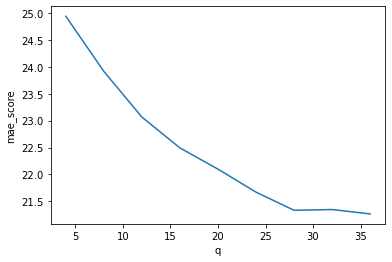

In [50]:
# utsunomiya 36
df_qth = search_best_q_value(_df, target_label="pollen_utsunomiya", plot=True)

In [57]:
# tokyo -> 12
df_qth = search_best_q_value(_df, target_label="pollen_tokyo", plot=True)

  0%|          | 0/9 [00:00<?, ?it/s]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[189]	valid_0's l1: 1.52412	valid_0's l2: 2.96857
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 1.00991	valid_0's l2: 1.99677
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 1.00075	valid_0's l2: 1.98435


 11%|█         | 1/9 [05:24<43:15, 324.41s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[44]	valid_0's l1: 2.23656	valid_0's l2: 7.28318
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[55]	valid_0's l1: 1.61484	valid_0's l2: 5.31691
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 1.5688	valid_0's l2: 5.17055


 22%|██▏       | 2/9 [11:22<39:01, 334.47s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[46]	valid_0's l1: 2.80766	valid_0's l2: 11.8655
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l1: 2.11757	valid_0's l2: 9.14412
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 2.06594	valid_0's l2: 8.92337


 33%|███▎      | 3/9 [18:37<36:27, 364.61s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l1: 3.46164	valid_0's l2: 18.5196
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 2.65867	valid_0's l2: 14.376
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 2.5603	valid_0's l2: 13.7206


 44%|████▍     | 4/9 [25:45<31:57, 383.56s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[64]	valid_0's l1: 4.24344	valid_0's l2: 27.9967
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[71]	valid_0's l1: 3.14721	valid_0's l2: 19.892
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 3.00846	valid_0's l2: 18.9903


 56%|█████▌    | 5/9 [32:45<26:18, 394.59s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[59]	valid_0's l1: 4.7679	valid_0's l2: 35.2027
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l1: 3.58702	valid_0's l2: 26.125
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 3.37398	valid_0's l2: 23.9508


 67%|██████▋   | 6/9 [40:08<20:27, 409.11s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[251]	valid_0's l1: 5.37927	valid_0's l2: 45.3143
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 4.05663	valid_0's l2: 33.4586
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 3.75081	valid_0's l2: 29.9663


 78%|███████▊  | 7/9 [47:17<13:49, 414.98s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's l1: 5.73885	valid_0's l2: 52.2899
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 4.44211	valid_0's l2: 40.1901
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l1: 4.08542	valid_0's l2: 35.8615


 89%|████████▉ | 8/9 [54:15<06:55, 415.95s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[78]	valid_0's l1: 6.07286	valid_0's l2: 59.3845
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 4.76592	valid_0's l2: 46.6855
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 4.33556	valid_0's l2: 40.8394


100%|██████████| 9/9 [1:01:14<00:00, 408.23s/it]


,0
4,12.217767
8,11.553697
12,11.440884
16,11.532452
20,11.756165
24,11.880485
28,12.107719
32,12.589253
36,13.065722


ValueError: Could not interpret input 'q'

  0%|          | 0/9 [00:00<?, ?it/s]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's l1: 1.47267	valid_0's l2: 2.80084
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 1.07056	valid_0's l2: 2.0972
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 1.03287	valid_0's l2: 2.03854


 11%|█         | 1/9 [05:32<44:19, 332.41s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's l1: 2.42489	valid_0's l2: 8.33192
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's l1: 1.72051	valid_0's l2: 5.89191
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 1.63084	valid_0's l2: 5.50999


 22%|██▏       | 2/9 [11:32<39:45, 340.72s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[175]	valid_0's l1: 3.13097	valid_0's l2: 13.8162
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 2.3279	valid_0's l2: 10.3861
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 2.21651	valid_0's l2: 9.87284


 33%|███▎      | 3/9 [18:24<36:12, 362.07s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[61]	valid_0's l1: 3.76966	valid_0's l2: 20.7331
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 2.84517	valid_0's l2: 15.5252
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 2.73215	valid_0's l2: 14.9583


 44%|████▍     | 4/9 [25:45<32:09, 385.85s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[62]	valid_0's l1: 4.19135	valid_0's l2: 25.9941
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 3.22502	valid_0's l2: 20.0998
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 3.11819	valid_0's l2: 19.4958


 56%|█████▌    | 5/9 [33:13<26:57, 404.41s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's l1: 4.66952	valid_0's l2: 33.995
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 3.66407	valid_0's l2: 26.4909
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 3.5003	valid_0's l2: 25.0613


 67%|██████▋   | 6/9 [41:23<21:30, 430.06s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[87]	valid_0's l1: 5.21874	valid_0's l2: 43.4021
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 4.04655	valid_0's l2: 32.7769
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l1: 3.85053	valid_0's l2: 30.7761


 78%|███████▊  | 7/9 [49:33<14:56, 448.07s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[60]	valid_0's l1: 5.77684	valid_0's l2: 53.737
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 4.38358	valid_0's l2: 38.8582
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 4.17422	valid_0's l2: 36.6674


 89%|████████▉ | 8/9 [59:10<08:06, 486.62s/it]

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 6.23874	valid_0's l2: 62.5882
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 4.71696	valid_0's l2: 45.3208
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 4.48386	valid_0's l2: 42.6985


100%|██████████| 9/9 [1:06:08<00:00, 440.96s/it]

[16.010558648640863, 14.969906408407773, 14.382608281376818, 13.895851931785918, 13.778954257817539, 13.724372199906787, 13.963591094302211, 14.047029301752053, 14.073599962917953]


,mae_score
q,
4,16.010559
8,14.969906
12,14.382608
16,13.895852
20,13.778954
24,13.724372
28,13.963591
32,14.047029
36,14.073600


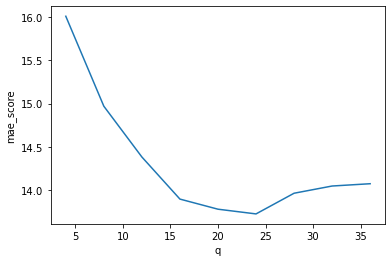

In [75]:
# chiba -> 24
df_qth = search_best_q_value(_df, target_label="pollen_chiba", plot=True)

# Model

In [76]:



# def metric_mae(y_true, y_pred):
#    score = mean_absolute_error(y_true, y_pred)
#    return "mae", score, False


In [77]:
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
import joblib


def train_lightgbm_with_cv(
    _df: pd.DataFrame,  # 学習データ
    df_test: pd.DataFrame,  # テストデータ
    target_label: str,  # target label
    label_cols: List[str] = [
        "pollen_utsunomiya",
        "pollen_chiba",
        "pollen_tokyo",
    ],
    unused_label: List[str] = [
        "datetime",
        "datetime_dt",        
    ],
    plot: bool = False,
    qth: int = 20
) -> Union[np.array, List[np.float], pd.DataFrame]:

    print(f"========={target_label}==========")
    print(f"qth = {qth}")

    cols = [col for col in _df.columns if col not in label_cols + unused_label]

    folds = TimeSeriesSplit(n_splits=Config.n_splits)
    scores = []
    prediction = np.zeros(len(df_test))
    imps_list = []

    for fold, (train_idx, val_idx) in enumerate(folds.split(_df)):
        print(f"=====fold {fold}=======")

        df_train = _df.loc[train_idx].reset_index(drop=True)
        df_val = _df.loc[val_idx].reset_index(drop=True)

        #print(df_val[["datetime", target_label]])

        print("train shape", df_train.shape, "test shape", df_val.shape)

        model = LGBMRegressor(random_state=Config.seed, n_estimators=1000)
        
        label = target_label
        label_savgol_window_size = 25
        
        # kotrying 氏のnotebookより 補正値を参考
        # vq = {'pollen_utsunomiya':20, 'pollen_chiba':20, 'pollen_tokyo':8}
        df_train = df_train[df_train[label] <= qth]
        df_val = df_val[df_val[label] <= qth]

        

        model.fit(
            #df_train[cols],
            df_train[cols],
            #df_train[label],
            savgol_filter(df_train[label], window_length=label_savgol_window_size, polyorder=2),
            eval_set=(df_val[cols], df_val[label]),
            early_stopping_rounds=1000,
            eval_metric="mae",
            verbose=-1,
        )

        # validation
        val_pred = model.predict(df_val[cols])
        val_score = mean_absolute_error(df_val[label], val_pred)
        scores.append(val_score)

        if plot:
            _df_val = df_val.copy()
            _df_val["pred"] = val_pred
            ax = sns.lineplot(data=_df_val, x="datetime_dt", y=label)
            ax = sns.lineplot(data=_df_val, x="datetime_dt", y="pred")
            plt.show()

        _pred = model.predict(_df_test[cols], num_iteration=model.best_iteration_)        
        prediction += _pred / Config.n_splits
        prediction = np.where(prediction < 0, 0, prediction)

        imps = model.feature_importances_
        imps_list.append(imps)

    imps = np.mean(imps_list, axis=0)
    df_imps = pd.DataFrame({"columns": _df[cols].columns.tolist(), "feat_imp": imps})
    df_imps = df_imps.sort_values("feat_imp", ascending=False).reset_index(drop=True)

    return prediction, scores, df_imps


=========pollen_utsunomiya==========
qth = 36
=====fold 0=======
train shape (4044, 901) test shape (4044, 901)
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[47]	valid_0's l1: 5.4639	valid_0's l2: 63.8817


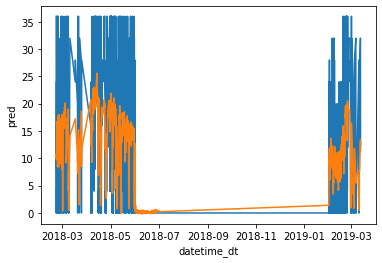

=====fold 1=======
train shape (8088, 901) test shape (4044, 901)
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[48]	valid_0's l1: 6.04271	valid_0's l2: 69.1915


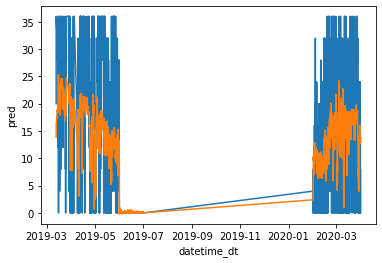

 fold_0 mae: 5.463901886355393
 fold_1 mae: 6.042707095409496
mean 5.753304490882445


In [78]:
#utsunomiya_prediction, scores, df_imps = train_lightgbm_with_split_by_year(
#    _df, _df_test, target_label="pollen_utsunomiya", plot=True
#)

utsunomiya_prediction, scores, df_imps = train_lightgbm_with_cv(
    _df, _df_test, target_label="pollen_utsunomiya", plot=True, qth=36
)

for i, score in enumerate(scores):
    print(f" fold_{i} mae: {score}")
print(f"mean {np.mean(scores)}")

utsunomiya_score = np.mean(scores)

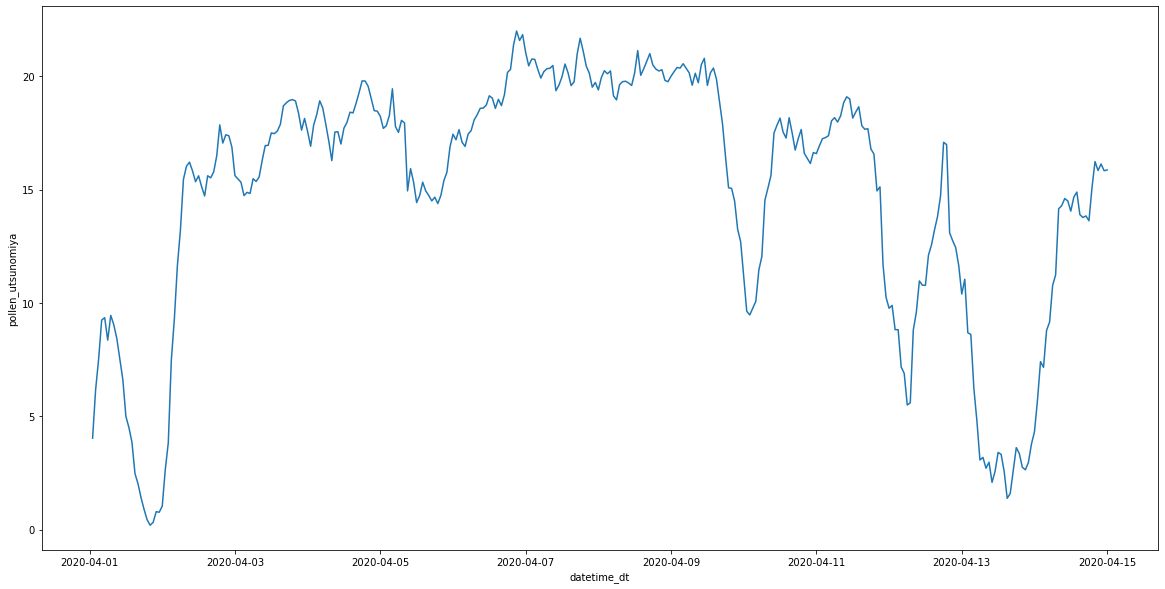

In [79]:
__df_test = _df_test.copy()
__df_test["pollen_utsunomiya"] = utsunomiya_prediction
plt.figure(figsize=(20, 10))
ax = sns.lineplot(data=__df_test, x="datetime_dt", y="pollen_utsunomiya")



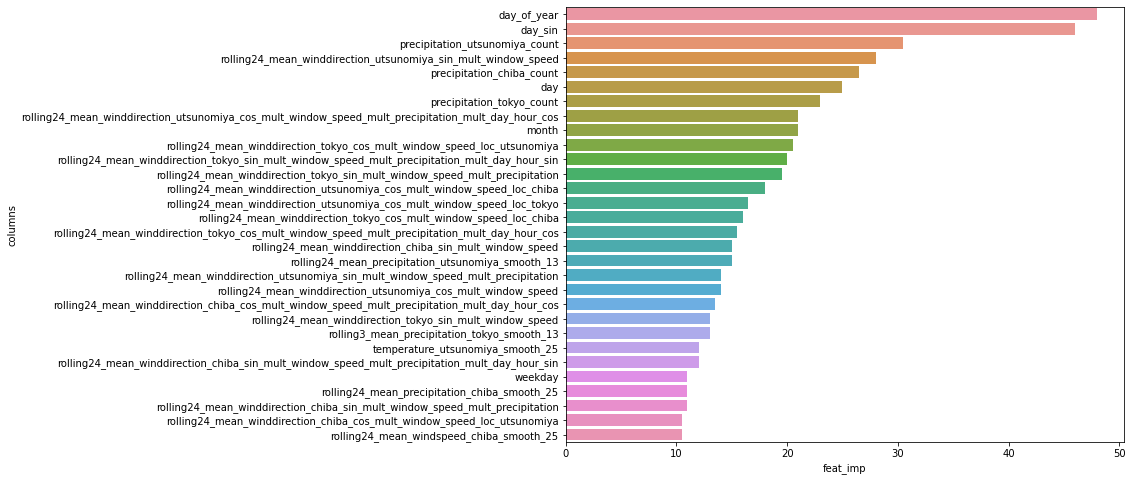

In [80]:
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=df_imps.head(30), x="feat_imp", y="columns")


# tokyo

=========pollen_tokyo==========
qth = 12
=====fold 0=======
train shape (4044, 901) test shape (4044, 901)
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[49]	valid_0's l1: 2.50867	valid_0's l2: 12.1187


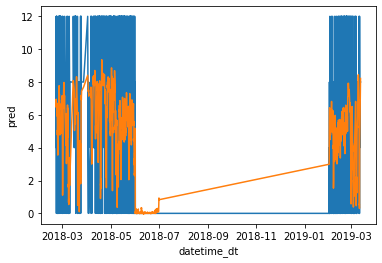

=====fold 1=======
train shape (8088, 901) test shape (4044, 901)
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[47]	valid_0's l1: 2.72677	valid_0's l2: 12.9421


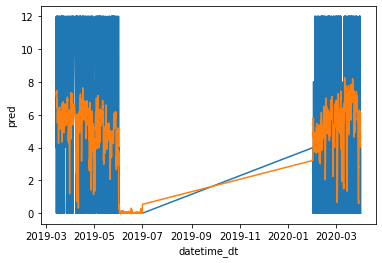

 fold_0 mae: 2.508671580798009
 fold_1 mae: 2.7267668935506237
mean: 2.6177192371743163


In [81]:
#tokyo_prediction, scores, df_imps = train_lightgbm_with_split_by_year(
#     _df, _df_test, target_label="pollen_tokyo", plot=True
#)

tokyo_prediction, scores, df_imps = train_lightgbm_with_cv(
     _df, _df_test, target_label="pollen_tokyo", plot=True, qth=12
)

for i, score in enumerate(scores):
    print(f" fold_{i} mae: {score}")
print(f"mean: {np.mean(scores)}")

tokyo_score = np.mean(scores)


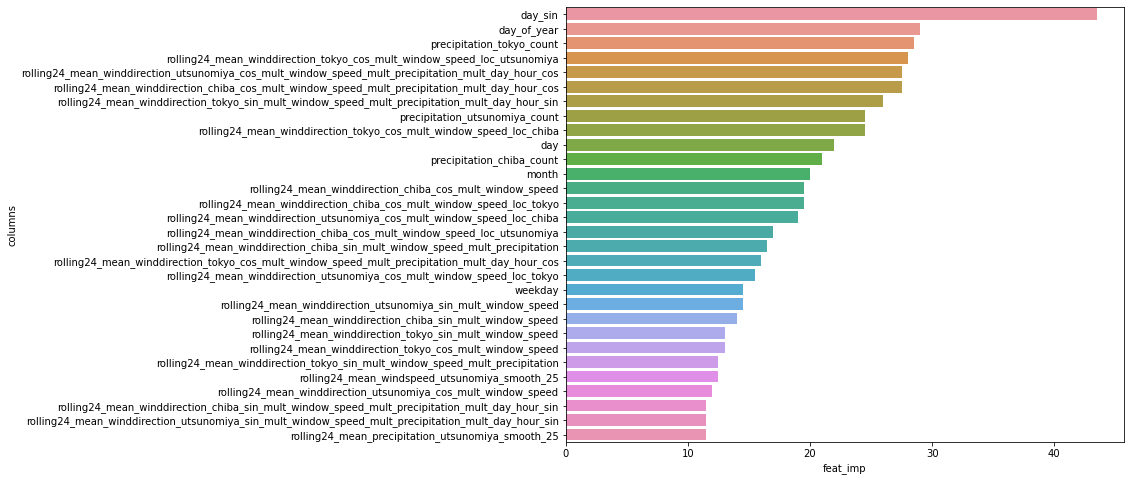

In [82]:
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=df_imps.head(30), x="feat_imp", y="columns")


# chiba

=========pollen_chiba==========
qth = 24
=====fold 0=======
train shape (4044, 901) test shape (4044, 901)
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's l1: 4.24592	valid_0's l2: 35.2086


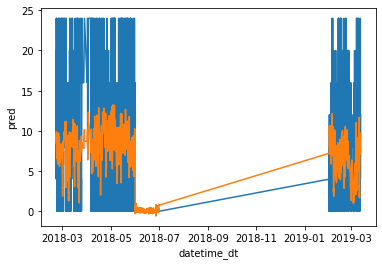

=====fold 1=======
train shape (8088, 901) test shape (4044, 901)
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[41]	valid_0's l1: 4.47365	valid_0's l2: 37.0782


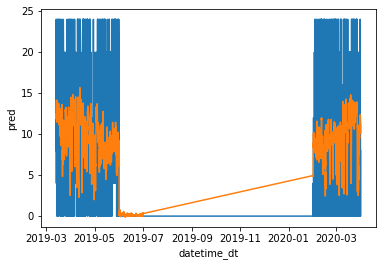

 fold_0 mae: 4.245924086248152
 fold_1 mae: 4.473654564409862
mean: 4.359789325329007


In [83]:
chiba_prediction, scores, df_imps = train_lightgbm_with_cv(
    _df, _df_test, target_label="pollen_chiba", plot=True, qth=24
)

# chiba_prediction, scores, df_imps = train_lightgbm_with_split_by_year(
#     _df, _df_test, target_label="pollen_chiba", plot=True
# )

for i, score in enumerate(scores):
    print(f" fold_{i} mae: {score}")
print(f"mean: {np.mean(scores)}")


chiba_score = np.mean(scores)


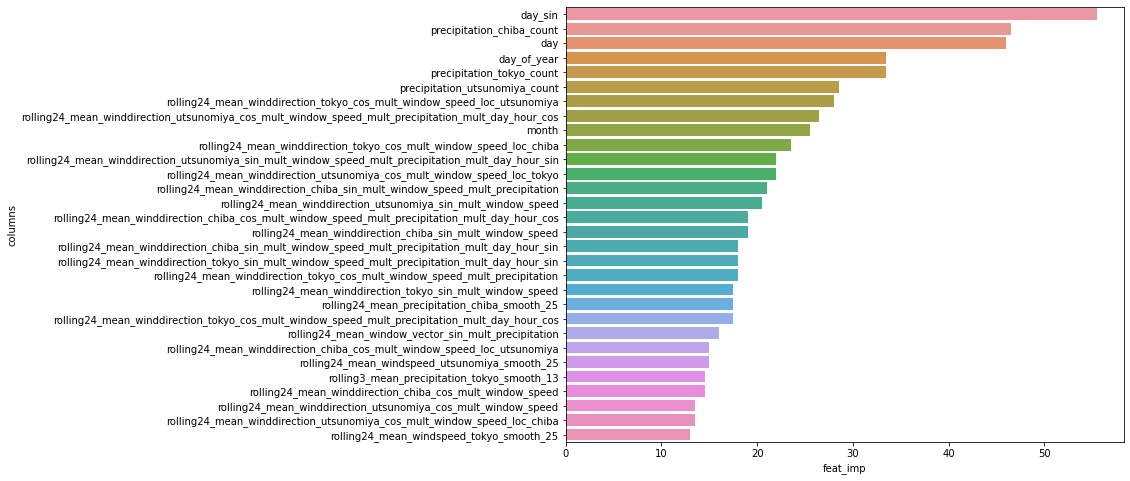

In [84]:
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=df_imps.head(30), x="feat_imp", y="columns")


# submission

In [85]:
df_sub = _df_test[["datetime"]]


In [86]:
df_sub["pollen_utsunomiya"] = utsunomiya_prediction
df_sub["pollen_chiba"] = chiba_prediction
df_sub["pollen_tokyo"] = tokyo_prediction


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [87]:
df_sub.head()
df_sub.to_csv(f"sub.csv", index=None)


In [88]:
utsunomiya_score, tokyo_score, chiba_score, np.mean([utsunomiya_score, tokyo_score, chiba_score])

(5.753304490882445, 2.6177192371743163, 4.359789325329007, 4.24360435112859)

# score
- 64.10566
- 122.26534
- 127.59514
- savgol_filterをラベルに追加: LB: 56.69182, CV: u 126.5, t 36.9, c 28.83
- savgol_filterを特徴量に追加 window size = 35  CV u 124.4, t 36.65, c: 29.22
- savgol_filterを特徴量に変更 window size = 35  (124.40695851120257, 36.659359871522675, 29.1962403298141)
- savgol_filterを特徴量に変更 window size = 35 -> 55  (126.44875318392432, 35.205501763280935, 28.273597737961566, 63.30) 
- 補正値を追加(正解が一定以下のデータのみ学習/検証に使う)　(3.8934261501532745, 4.310516372229987, 28.273597737961566, 12.159180086781609)　LB: 32.22890
- 補正値設定ミスってたので修正 (3.8934261501532745, 2.0175388500923255, 4.304978657590222, 3.405314552611941) LB: 13.95514

- 千葉だけ_cvじゃなかったので修正 (3.8934261501532745, 2.0175388500923255, 4.137336230149423, 3.3494337434650077) LB:13.56184
    - ちなみに split_by_yearは14.34389でしたのでtime_series_cvのほうが良さそう。
    - くわえて、CVとは一応相関してそう

- 風向のone-hotを追加 (3.8906922262087886, 2.017560176147346, 4.138983768571907, 3.3490787236426804)
- roll 36, 48を追加 (3.904820557208936, 2.00576047365233, 4.164051128419937, 3.3582107197604008) -> 下がったので不採用
- ノイズ除去で元のやつも残すように変更、(3.916733830559269, 1.9956051999047397, 4.0699312564943355, 3.327423428986115)
- savgol_filterを特徴量に変更 window size = 55 -> 25 (3.884649061928195, 1.9879375591978263, 4.0603229971309815, 3.3109698727523345)
- savgol_filterを特徴量に追加 window size = 25, 13を新規追加 (3.8754100405526666, 1.984153386413598, 4.065806808103186, 3.3084567450231503)
- savgol_filterを特徴量に追加 window size = 25, 13, 7を新規追加 (3.8819300003928845, 1.9858853018847262, 4.050534532597559, 3.306116611625056)
- labelへのsavgol_filterのwindow sizeを25-> 13に変更  (3.883470658393416, 2.004070969620379, 4.064861992348034, 3.3174678734539427) わるくなったので不採用
- labelへのsavgol_filterのwindow sizeを25-> 37に変更  (3.906864140705683, 1.9963961518020925, 4.111649135182413, 3.338303142563396) わるくなったので不採用
- window speed * window direct cos/sinを追加 (3.8771389594171985, 1.9850645688206736, 4.05984027848512, 3.307347935574331)
- window speed * window direct cos/sin / 降水量 を追加　(3.877556773607786, 1.9875229054957329, 4.042222950328732, 3.3024342098107504)
- smooth の roll を追加 (3.9122461555568577, 1.9667051031784824, 4.085230575131414, 3.321393944622251) LB 13.61288 東京は下がったが、他の地域はあがってしまった。　地域ごとに特徴量を変えた方がいいかもしれない。 

- 3県の地理関係を追加 (3.9284410101986476, 1.9647714009055983, 4.068930186186604, 3.3207141990969498)
- 3県の地理関係のrollを追加 (3.910972561302266, 1.9773775759843935, 4.062062235369705, 3.316804124218788) LB:13.65122
- data_v2に変更。目的変数が負のものは削除 (3.48332439150602, 1.827334834283675, 3.7730654662311234, 3.0279082306736065) LB: 13.11687 
- 地理関係のrollがcos だけだったので、sinも追加　(3.4847560761408323, 1.8298810762884554, 3.805017383126936, 3.039884845185408)
- 雨の日カウント (3.4788018301803905, 1.8225884153507086, 3.834963170677646, 3.0454511387362486) LB: 13.11894
- 未来の降水量rollingを追加 (3.499786823304113, 1.8271401025293814, 3.843773306837279, 3.0569000775569246) 下がったのでなし
- hour sin など追加 (3.494998026616688, 1.8284509473076827, 3.829350742186947, 3.0509332387037724)
- qの値の調整　(5.753304490882445, 2.6177192371743163, 4.359789325329007, 4.24360435112859) トレンドが変わったのでいったん提出 -> LB: 14.09194